# Imports

In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import nn
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 
import time

# Functions

In [2]:
def c_l2(x, y):
    return torch.dist(x, y, 2)**2

def d_l2(x, y):
    return torch.dist(x, y, 2)**2

def gaussian_sampler_2d(gaussian_center, cov_matrix):
    mu_distr = MultivariateNormal(gaussian_center, cov_matrix)
    return mu_distr

def gaussian_data_sampling(gaussian_center, cov_matrix, data_num, device = None):
    sampler = gaussian_sampler_2d(gaussian_center, cov_matrix)
    data = sampler.sample(sample_shape=torch.Size([data_num]))
    if (device is not None):
        data = data.to(device)

    return data
    
def plot_data_gaussians(data_mu, data_nu):
    fig = plt.figure(figsize=(10,10))

    plt.xlabel(r'$x$') 
    plt.ylabel(r'$y$') 
    plt.title('1 and 8 gaussians') 

    plt.scatter(data_mu[:, 0], data_mu[:, 1], label = r'$\mu$-s gaussian', marker='+')
    plt.scatter(data_nu[:, 0], data_nu[:, 1], label = r'$\nu$-s gaussians', marker='+', color = 'r')

    plt.legend()
    plt.grid(True) 

def gaussian_data_sampling_nu(centers_nu, cov_matrix, batch_size, random_state, device = None):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    index_to_choice = np.random.randint(centers_nu.shape[0], size = batch_size)
    data_nu = gaussian_data_sampling(centers_nu[index_to_choice[0]], cov_matrix, 1)
    for i in range(1, batch_size):
        cur_data_nu = gaussian_data_sampling(centers_nu[index_to_choice[i]], cov_matrix, 1)
        data_nu = torch.cat((data_nu, cur_data_nu), 0)
    
    if (device is not None):
        data_nu = data_nu.to(device)

    return data_nu

def gaussian_data_sampling_mu(center_mu, cov_matrix, batch_size, random_state, device = None):
    torch.manual_seed(random_state)
    return gaussian_data_sampling(center_mu, cov_matrix, batch_size, device)

def index_sampler(nu_data_shape, batch_size, random_state, device = None):
    np.random.seed(random_state)
    indexes_to_choice = np.random.randint(nu_data_shape, size = batch_size)
    indexes_to_choice = torch.from_numpy(indexes_to_choice)
    
    if (device is not None):
        indexes_to_choice = indexes_to_choice.to(device)
        
    return indexes_to_choice

def nu_sampler_from_discrete_distr(nu_data, batch_size, random_state, device = None):
    indexes_to_choice = index_sampler(nu_data_shape = nu_data.shape[0], 
                                      batch_size = batch_size, 
                                      random_state = random_state, 
                                      device = device)
    
    return nu_data[indexes_to_choice, :]

# Constants

In [3]:
random_state_default = 42

eps_default = 1e-2
lr_default = 1e-3
reg_mode_default = 'l2'
device_default = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype_default = torch.float64
epochs_default = 10
batch_size_default = 128
batch_size_validate_default = 1024

random_states_train_default = range(epochs_default)

scale = 2.
nu_centers = [
            [1, 0],
            [-1, 0],
            [0, 1],
            [0, -1],
            [1./np.sqrt(2), 1./np.sqrt(2)],
            [1./np.sqrt(2), -1./np.sqrt(2)],
            [-1./np.sqrt(2), 1./np.sqrt(2)],
            [-1./np.sqrt(2), -1./np.sqrt(2)]
          ]
gaussian_num = len(nu_centers)
centers_nu_default = torch.Tensor([(scale*x,scale*y) for x,y in nu_centers])
center_mu_default = torch.zeros(2)
sigma = torch.Tensor([0.02])
init_cov_matrix = torch.eye(2)
cov_matrix_default = sigma*init_cov_matrix

data_mu_validate_default = gaussian_data_sampling_mu(center_mu_default, 
                                                     cov_matrix_default, 
                                                     batch_size_validate_default, 
                                                     random_state_default, 
                                                     device = device_default)
data_nu_validate_default = gaussian_data_sampling_nu(centers_nu_default, 
                                                     cov_matrix_default, 
                                                     batch_size_validate_default, 
                                                     random_state_default, 
                                                     device = device_default)

nu_sampler_default = partial(nu_sampler_from_discrete_distr, device = device_default)
mu_sampler_default = partial(gaussian_data_sampling_mu, 
                                   center_mu = center_mu_default, 
                                   cov_matrix = cov_matrix_default, 
                                   device = device_default)

# Class Neural_OT

In [91]:
class Neural_OT:

    def __init__(self, f_net, reg_mode = reg_mode_default, eps = eps_default, c = c_l2,
                 d = d_l2,
                 dtype = dtype_default, device = device_default):

        self.f_net = f_net
        self.reg_mode = reg_mode
        self.eps = eps
        self.c = c
        self.d = d
        self.dtype = dtype
        self.device = device
        
    def dual_OT_loss_estimation(self, u_batch, v_batch, x_batch, y_batch):
        
        num_estimators = x_batch.shape[0]
        
        loss_u_part = torch.sum(u_batch)
        loss_v_part = torch.sum(v_batch)
        
        F_eps = torch.zeros(1, dtype=self.dtype, device=self.device)
        for i in range(num_estimators):
            
            cur_F_eps = torch.zeros(1, dtype=self.dtype, device=self.device)
            if self.reg_mode == 'l2':
                relu = nn.ReLU()
                val = relu(u_batch[i] + v_batch[i] - self.c(x_batch[i], y_batch[i]))
                cur_F_eps = -(val**2)/(4.0*self.eps)
            
            if self.reg_mode == 'entropy':
                val = (u_batch[i] + v_batch[i] - self.c(x_batch[i], y_batch[i]))/self.eps
                cur_F_eps = -self.eps*torch.exp(val)

            F_eps += cur_F_eps
        
        loss = (loss_u_part + loss_v_part + F_eps)/num_estimators
        
        return -loss

        
    def mapping_OT_loss_estimation(self, u_batch, v_batch, x_batch, y_batch, map_batch):

        num_estimators = x_batch.shape[0]
        сur_loss = torch.zeros(1, dtype=self.dtype, device=self.device)
        for i in range(num_estimators):
            
            cur_H_eps = torch.zeros(1, dtype=self.dtype, device=self.device)
            
            if self.reg_mode == 'l2':
                relu = nn.ReLU()
                val = relu(u_batch[i] + v_batch[i] - self.c(x_batch[i], y_batch[i]))
                cur_H_eps = val/(2*self.eps)

            if self.reg_mode == 'entropy':
                val = (u_batch[i] + v_batch[i] - self.c(x_batch[i], y_batch[i]))/self.eps
                cur_H_eps = torch.exp(val)
            #print(cur_H)
            сur_loss += self.d(y_batch[i], map_batch[i])*cur_H_eps

        return сur_loss/num_estimators

In [92]:
class Neural_OT_net_vector(Neural_OT):
    
    def __init__(self, f_net, u_net, v_size = batch_size_validate_default, 
                 reg_mode = reg_mode_default, eps = eps_default, 
                 dtype = dtype_default, device = device_default):

        Neural_OT.__init__(self, f_net, reg_mode = reg_mode_default, eps = eps_default, 
                 dtype = dtype_default, device = device_default)

        self.u = u_net 
        self.v_size = v_size
        self.v = torch.zeros(self.v_size, dtype = self.dtype, requires_grad=True, device=self.device)

        
    def stochastic_OT_computation(self, epochs = epochs_default, batch_size = batch_size_default,
                                  random_state_val = random_state_default,
                                  random_states_train = random_states_train_default,
                                  mu_sampler = mu_sampler_default, 
                                  index_sampler = index_sampler,
                                  nu_data = data_nu_validate_default,
                                  optimizer_mode = None, 
                                  lr = lr_default,
                                  loss_arr_batch = [],
                                  loss_arr_validate = []):

        trainable_params = list(self.u.parameters()) + [self.v]
        
        if not optimizer_mode:
            optimizer = torch.optim.Adam(trainable_params, lr = lr)
        elif optimizer_mode == 'SGD':
            optimizer = torch.optim.SGD(trainable_params, lr = lr)

        for epoch in range(epochs):
            
            print("------------------------------")
            print(f"Epoch_num = {epoch}")

            start_time = time.time()
            
            x_batch = mu_sampler(random_state = random_states_train[epoch], batch_size = batch_size)
            #print(x_batch.device)
            
            indexes_to_choice = index_sampler(nu_data_shape = nu_data.shape[0], 
                                              batch_size = batch_size, 
                                              random_state = random_states_train[epoch], 
                                              device = self.device)
            y_batch = nu_data[indexes_to_choice, :]
            u_batch = (self.u)(x_batch)
            v_batch = (self.v)[indexes_to_choice]
            
            loss_batch = self.dual_OT_loss_estimation(u_batch, v_batch, x_batch, y_batch)
            
            optimizer.zero_grad()

            loss_batch.backward()
            optimizer.step()


            end_time = time.time()
            consumed_time = end_time - start_time
            print(f"Consumed time = {consumed_time} seconds")

            loss_batch_maximization = -loss_batch.item()
            print(f"Loss estimation on sampled data = {loss_batch_maximization}")
            
            x_batch_val = mu_sampler(random_state = random_state_val, batch_size = nu_data.shape[0])
            y_batch_val = nu_data
            
            self.u.eval()
            self.v.requires_grad_(False)
            
            u_batch_val = (self.u)(x_batch_val)
            v_batch_val = self.v
            
            loss_val = self.dual_OT_loss_estimation(u_batch_val, v_batch_val, 
                                                         x_batch_val, y_batch_val)
            
            loss_val_maximization = -loss_val.item()
            print(f"Loss estimation on validation data = {loss_val_maximization}")

            loss_arr_batch.append(loss_batch_maximization)
            loss_arr_validate.append(loss_val_maximization)
        
    def optimal_map_learning(self, epochs = epochs_default, batch_size = batch_size_default,
                                  random_state_val = random_state_default,
                                  random_states_train = random_states_train_default,
                                  mu_sampler = mu_sampler_default, 
                                  index_sampler = index_sampler,
                                  nu_data = data_nu_validate_default,
                                  optimizer_mode = None, 
                                  lr = lr_default,
                                  loss_arr_batch = [],
                                  loss_arr_validate = []):
        
        trainable_params = list(self.f_net.parameters())
        
        if not optimizer_mode:
            optimizer = torch.optim.Adam(trainable_params, lr = lr)
        elif optimizer_mode == 'SGD':
            optimizer = torch.optim.SGD(trainable_params, lr = lr)
            

        for epoch in range(epochs):
            
            print("------------------------------")
            print(f"Epoch_num = {epoch}")

            start_time = time.time()
            
            x_batch = mu_sampler(random_state = random_states_train[epoch], batch_size = batch_size)
            #print(x_batch.device)
            
            indexes_to_choice = index_sampler(nu_data_shape = nu_data.shape[0], 
                                              batch_size = batch_size, 
                                              random_state = random_states_train[epoch], 
                                              device = self.device)
            y_batch = nu_data[indexes_to_choice, :]
            u_batch = (self.u)(x_batch)
            v_batch = (self.v)[indexes_to_choice]
            
            self.f_net.train()
            map_batch = (self.f_net)(x_batch)
            
            loss_batch = self.mapping_OT_loss_estimation(u_batch, v_batch, x_batch, y_batch, map_batch)
            
            optimizer.zero_grad()

            loss_batch.backward()
            optimizer.step()


            end_time = time.time()
            consumed_time = end_time - start_time
            print(f"Consumed time = {consumed_time} seconds")

            loss_batch = loss_batch.item()
            print(f"Loss estimation on sampled data = {loss_batch}")
            
            x_batch_val = mu_sampler(random_state = random_state_val, batch_size = nu_data.shape[0])
            y_batch_val = nu_data
            
            u_batch_val = (self.u)(x_batch_val)
            v_batch_val = self.v
            
            self.f_net.eval()
            map_batch = (self.f_net)(x_batch)
            
            loss_val = self.mapping_OT_loss_estimation(u_batch, v_batch, x_batch, y_batch, map_batch)
            
            loss_val = loss_val.item()
            print(f"Loss estimation on validation data = {loss_val}")

            loss_arr_batch.append(loss_batch)
            loss_arr_validate.append(loss_val)

# Testing

In [93]:
torch.manual_seed(random_state_default)
D_in = 2
D_out = 1
H = 128
u_net_default = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, 2*H),
    torch.nn.ReLU(),
    torch.nn.Linear(2*H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, 1),
)

f_D_out = D_in

f_net_default = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, 2*H),
    torch.nn.ReLU(),
    torch.nn.Linear(2*H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, f_D_out),
)

u_net_default.to(device_default)
f_net_default.to(device_default)

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=2, bias=True)
)

In [94]:
eps = .002
default_experiment = Neural_OT_net_vector(f_net = f_net_default, 
                                          u_net = u_net_default,
                                          eps = eps)

In [95]:
loss_arr_batch = []
loss_arr_validate = []

lr = 1e-3

epochs = 50
random_states_train = range(epochs)

batch_size = 1024

default_experiment.stochastic_OT_computation(lr = lr, epochs = epochs,
                                             batch_size = batch_size,
                                             random_states_train = random_states_train,
                                             loss_arr_batch = loss_arr_batch,
                                             loss_arr_validate = loss_arr_validate)

------------------------------
Epoch_num = 0
Consumed time = 0.35150718688964844 seconds
Loss estimation on sampled data = 0.004876838997006416
Loss estimation on validation data = 0.09802084604667677
------------------------------
Epoch_num = 1
Consumed time = 0.2810072898864746 seconds
Loss estimation on sampled data = 0.098430128809274
Loss estimation on validation data = 0.18168361949606687
------------------------------
Epoch_num = 2
Consumed time = 0.28931188583374023 seconds
Loss estimation on sampled data = 0.1823876514492314
Loss estimation on validation data = 0.263003993833744
------------------------------
Epoch_num = 3
Consumed time = 0.28892993927001953 seconds
Loss estimation on sampled data = 0.2630638291153939
Loss estimation on validation data = 0.349095604494211
------------------------------
Epoch_num = 4
Consumed time = 0.30108213424682617 seconds
Loss estimation on sampled data = 0.349558464251147
Loss estimation on validation data = 0.4467708097349966
-----------

Loss estimation on validation data = 2.7129279870378795
------------------------------
Epoch_num = 42
Consumed time = 0.29300618171691895 seconds
Loss estimation on sampled data = 2.6704632074428725
Loss estimation on validation data = 2.7069333068787698
------------------------------
Epoch_num = 43
Consumed time = 0.2836785316467285 seconds
Loss estimation on sampled data = 2.6536699627985785
Loss estimation on validation data = 2.7068645816499526
------------------------------
Epoch_num = 44
Consumed time = 0.3094305992126465 seconds
Loss estimation on sampled data = 2.6730562287437074
Loss estimation on validation data = 2.711593436335783
------------------------------
Epoch_num = 45
Consumed time = 0.28885507583618164 seconds
Loss estimation on sampled data = 2.6958947833241367
Loss estimation on validation data = 2.7214129287961764
------------------------------
Epoch_num = 46
Consumed time = 0.2910346984863281 seconds
Loss estimation on sampled data = 2.7311953869777055
Loss esti

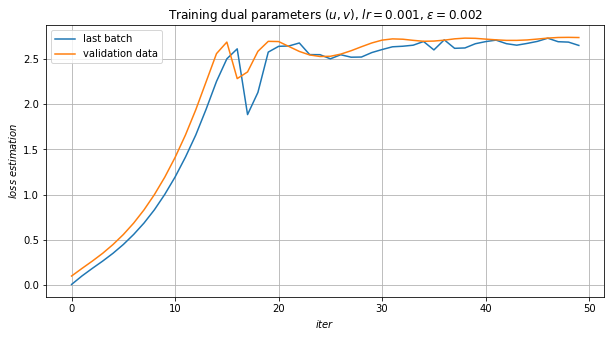

In [96]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$iter$') 
plt.ylabel(r'$loss \; estimation$') 
plt.title(fr'Training dual parameters $(u, v)$, $lr = {lr}$, $\varepsilon = {eps}$') 

plt.plot(random_states_train, loss_arr_batch, label = r'last batch')
plt.plot(random_states_train, loss_arr_validate, label = r'validation data')

plt.legend()
plt.grid(True) 

In [98]:
f_loss_arr_batch = []
f_loss_arr_validate = []

lr = 1e-6

epochs = 100
shift = 1000
random_states_train = range(shift, epochs + shift)

batch_size = 1024

default_experiment.optimal_map_learning(lr = lr, epochs = epochs,
                                             batch_size = batch_size,
                                             random_states_train = random_states_train,
                                             optimizer_mode = optimizer_mode,
                                             loss_arr_batch = f_loss_arr_batch,
                                             loss_arr_validate = f_loss_arr_validate)

------------------------------
Epoch_num = 0
Consumed time = 0.42284250259399414 seconds
Loss estimation on sampled data = 3.6517052880953997
Loss estimation on validation data = 3.651703502284363
------------------------------
Epoch_num = 1
Consumed time = 0.42324042320251465 seconds
Loss estimation on sampled data = 3.354967210208997
Loss estimation on validation data = 3.3549662104342133
------------------------------
Epoch_num = 2
Consumed time = 0.41752076148986816 seconds
Loss estimation on sampled data = 5.163031041156501
Loss estimation on validation data = 5.163028123322874
------------------------------
Epoch_num = 3
Consumed time = 0.4175453186035156 seconds
Loss estimation on sampled data = 4.2783168814494275
Loss estimation on validation data = 4.27831575111486
------------------------------
Epoch_num = 4
Consumed time = 0.42702174186706543 seconds
Loss estimation on sampled data = 4.190936537110247
Loss estimation on validation data = 4.190935336868279
-------------------

Loss estimation on validation data = 4.041189938841853
------------------------------
Epoch_num = 42
Consumed time = 0.4165835380554199 seconds
Loss estimation on sampled data = 4.954499095059873
Loss estimation on validation data = 4.95449619727151
------------------------------
Epoch_num = 43
Consumed time = 0.4212830066680908 seconds
Loss estimation on sampled data = 3.169536775589222
Loss estimation on validation data = 3.1695347005152144
------------------------------
Epoch_num = 44
Consumed time = 0.4165527820587158 seconds
Loss estimation on sampled data = 3.6677437945618294
Loss estimation on validation data = 3.667742796766106
------------------------------
Epoch_num = 45
Consumed time = 0.4167599678039551 seconds
Loss estimation on sampled data = 3.8416842371807434
Loss estimation on validation data = 3.8416831074864604
------------------------------
Epoch_num = 46
Consumed time = 0.4255955219268799 seconds
Loss estimation on sampled data = 3.5553189318743534
Loss estimation 

Loss estimation on validation data = 4.637634254225077
------------------------------
Epoch_num = 84
Consumed time = 0.4223611354827881 seconds
Loss estimation on sampled data = 3.0774675976717845
Loss estimation on validation data = 3.077466833172366
------------------------------
Epoch_num = 85
Consumed time = 0.4180760383605957 seconds
Loss estimation on sampled data = 4.619563916916377
Loss estimation on validation data = 4.6195610088907415
------------------------------
Epoch_num = 86
Consumed time = 0.41426658630371094 seconds
Loss estimation on sampled data = 3.9771070101996884
Loss estimation on validation data = 3.9771024450892583
------------------------------
Epoch_num = 87
Consumed time = 0.41449570655822754 seconds
Loss estimation on sampled data = 2.833941911929287
Loss estimation on validation data = 2.833941333228722
------------------------------
Epoch_num = 88
Consumed time = 0.41195082664489746 seconds
Loss estimation on sampled data = 3.879632228439732
Loss estimati

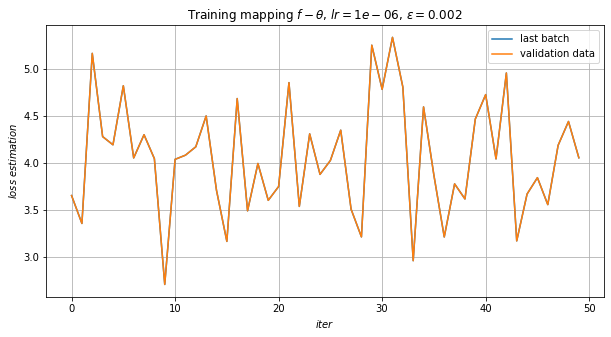

In [75]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$iter$') 
plt.ylabel(r'$loss \; estimation$') 
plt.title(r'Training mapping $f-\theta$, $lr = {}$, $\varepsilon = {}$'.format(lr, eps)) 

plt.plot(range(len(random_states_train)), f_loss_arr_batch, label = r'last batch')
plt.plot(range(len(random_states_train)), f_loss_arr_validate, label = r'validation data')

plt.legend()
plt.grid(True) 

In [76]:
default_experiment.f_net = f_net_default

f_loss_arr_batch = []
f_loss_arr_validate = []

lr = 1e-8
optimizer_mode = 'SGD'

epochs = 50
shift = 1000
random_states_train = range(shift, epochs + shift)

batch_size = 1024

default_experiment.optimal_map_learning(lr = lr, epochs = epochs,
                                             batch_size = batch_size,
                                             random_states_train = random_states_train,
                                             optimizer_mode = optimizer_mode,
                                             loss_arr_batch = f_loss_arr_batch,
                                             loss_arr_validate = f_loss_arr_validate)

------------------------------
Epoch_num = 0
Consumed time = 0.4354209899902344 seconds
Loss estimation on sampled data = 3.651702887029387
Loss estimation on validation data = 3.6517028581583872
------------------------------
Epoch_num = 1
Consumed time = 0.419750452041626 seconds
Loss estimation on sampled data = 3.3549646520987153
Loss estimation on validation data = 3.3549646520987153
------------------------------
Epoch_num = 2
Consumed time = 0.46459245681762695 seconds
Loss estimation on sampled data = 5.163028123788536
Loss estimation on validation data = 5.163028116570786
------------------------------
Epoch_num = 3
Consumed time = 0.436629056930542 seconds
Loss estimation on sampled data = 4.278316793323029
Loss estimation on validation data = 4.278316793323029
------------------------------
Epoch_num = 4
Consumed time = 0.4212980270385742 seconds
Loss estimation on sampled data = 4.190937922336161
Loss estimation on validation data = 4.190937892533839
-----------------------

Consumed time = 0.412081241607666 seconds
Loss estimation on sampled data = 4.954557937708159
Loss estimation on validation data = 4.954557937708159
------------------------------
Epoch_num = 43
Consumed time = 0.4205358028411865 seconds
Loss estimation on sampled data = 3.1695784254116006
Loss estimation on validation data = 3.169578406668734
------------------------------
Epoch_num = 44
Consumed time = 0.4227309226989746 seconds
Loss estimation on sampled data = 3.667773663823027
Loss estimation on validation data = 3.667773663823027
------------------------------
Epoch_num = 45
Consumed time = 0.426044225692749 seconds
Loss estimation on sampled data = 3.841728504106868
Loss estimation on validation data = 3.84172852645861
------------------------------
Epoch_num = 46
Consumed time = 0.4188675880432129 seconds
Loss estimation on sampled data = 3.555339848215226
Loss estimation on validation data = 3.555339803977404
------------------------------
Epoch_num = 47
Consumed time = 0.4247

In [57]:
default_experiment.f_net = f_net_default

f_loss_arr_batch = []
f_loss_arr_validate = []

lr = 1e-9

epochs = 40
shift = 50
random_states_train = range(shift, epochs + shift)

batch_size = 1024

default_experiment.optimal_map_learning(lr = lr, epochs = epochs,
                                             batch_size = batch_size,
                                             random_states_train = random_states_train,
                                             optimizer_mode = optimizer_mode,
                                             loss_arr_batch = f_loss_arr_batch,
                                             loss_arr_validate = f_loss_arr_validate)

------------------------------
Epoch_num = 0
Consumed time = 0.4166684150695801 seconds
Loss estimation on sampled data = 4.3717439036408905
Loss estimation on validation data = 4.3717439036408905
------------------------------
Epoch_num = 1
Consumed time = 0.40881967544555664 seconds
Loss estimation on sampled data = 3.414099913148675
Loss estimation on validation data = 3.414099913148675
------------------------------
Epoch_num = 2
Consumed time = 0.40897202491760254 seconds
Loss estimation on sampled data = 3.6016420939413365
Loss estimation on validation data = 3.6016420939413365
------------------------------
Epoch_num = 3
Consumed time = 0.41184401512145996 seconds
Loss estimation on sampled data = 3.7945407014340162
Loss estimation on validation data = 3.7945407014340162
------------------------------
Epoch_num = 4
Consumed time = 0.41088318824768066 seconds
Loss estimation on sampled data = 4.775277610402554
Loss estimation on validation data = 4.775277610402554
---------------

Loss estimation on validation data = 4.303611285431543
------------------------------
Epoch_num = 42
Consumed time = 0.4108290672302246 seconds
Loss estimation on sampled data = 4.241199906915426
Loss estimation on validation data = 4.241199906915426
------------------------------
Epoch_num = 43
Consumed time = 0.4098966121673584 seconds
Loss estimation on sampled data = 3.5054316885070875
Loss estimation on validation data = 3.5054316885070875
------------------------------
Epoch_num = 44
Consumed time = 0.4315524101257324 seconds
Loss estimation on sampled data = 3.696224946528673
Loss estimation on validation data = 3.696224946528673
------------------------------
Epoch_num = 45
Consumed time = 0.5982294082641602 seconds
Loss estimation on sampled data = 4.161398031516001
Loss estimation on validation data = 4.161398031516001
------------------------------
Epoch_num = 46
Consumed time = 0.41243696212768555 seconds
Loss estimation on sampled data = 3.8366090363560943
Loss estimation 

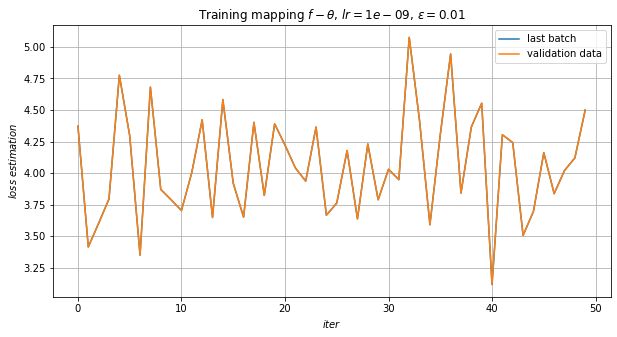

In [58]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$iter$') 
plt.ylabel(r'$loss \; estimation$') 
plt.title(r'Training mapping $f-\theta$, $lr = {}$, $\varepsilon = {}$'.format(lr, eps)) 

plt.plot(range(len(random_states_train)), f_loss_arr_batch, label = r'last batch')
plt.plot(range(len(random_states_train)), f_loss_arr_validate, label = r'validation data')

plt.legend()
plt.grid(True) 

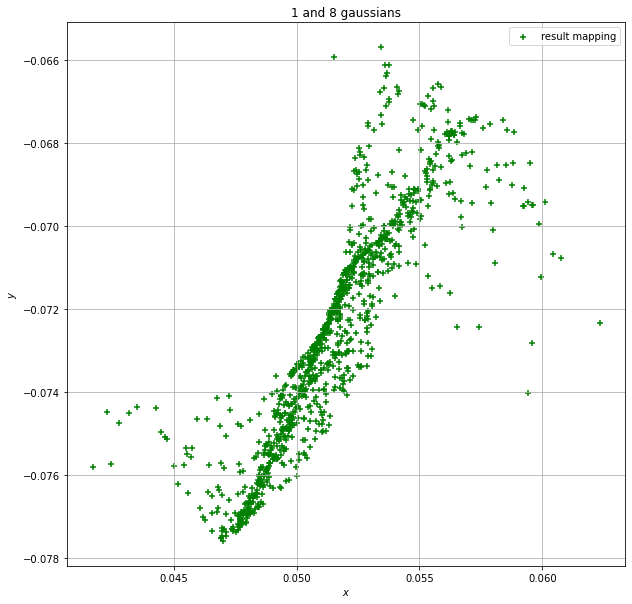

In [77]:
fig = plt.figure(figsize=(10,10))

plt.xlabel(r'$x$') 
plt.ylabel(r'$y$') 
plt.title('1 and 8 gaussians') 


data_nu_validate_plot = data_nu_validate_default.cpu().detach().numpy()
data_mu_validate_plot = mu_sampler_default(random_state = random_state_default, 
                         batch_size = data_nu_validate_plot.shape[0])

default_experiment.f_net.eval()
mapping = default_experiment.f_net(data_mu_validate_plot)
mapping = mapping.cpu().detach().numpy()

data_mu_validate_plot = data_mu_validate_plot.cpu().detach().numpy()

#plt.scatter(data_mu[:, 0], data_mu[:, 1], label = r'$\mu$-s gaussian', marker='+')
#plt.scatter(data_nu_validate_plot[:, 0], data_nu_validate_plot[:, 1], 
#            label = r'$\nu$-s gaussians', marker='+', color = 'r')

plt.scatter(mapping[:, 0], mapping[:, 1], 
            label = r'result mapping', marker='+', color = 'g')

#plt.scatter(data_mu_validate_plot[:, 0], data_mu_validate_plot[:, 1], 
#            label = r'$\mu$-s gaussians', marker='+')

plt.legend()
plt.grid(True) 